In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import gc

import lightgbm as lgb
from sklearn import preprocessing
from sklearn import pipeline
from sklearn import impute
from scipy.optimize import minimize
from scipy.stats import beta

import optuna
from optuna.visualization import (
    plot_contour
    , plot_edf
    , plot_intermediate_values
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances
    , plot_slice
)

import sys
sys.path.append("../utils")
from resample import mixup


pd.set_option('display.max_columns', None)

import plotly.express as px
import plotly.io as pio
pio.renderers.default = "png"

/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


***
## loading data

In [2]:
input_path = "../data/raw"

train = pd.read_csv(f"{input_path}/train.csv")
test  = pd.read_csv(f"{input_path}/test.csv")
greeks = pd.read_csv(f"{input_path}/greeks.csv")

train.columns = [col.strip() for col in train.columns]
test.columns = [col.strip() for col in test.columns]

# available features
input_cols = train.columns[1:-1]
categ_cols = ["EJ"]

# we extend train with dummies from greeks
dummies = pd.get_dummies(greeks[["Alpha","Beta","Gamma","Delta"]])
train[dummies.columns] = dummies

# encode of categorical features
encoder = preprocessing.LabelEncoder().fit(train["EJ"])
train["EJ"] = encoder.transform(train["EJ"]).astype(int)
test["EJ"] = encoder.transform(test["EJ"]).astype(int)

display(train)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha_A,Alpha_B,Alpha_D,Alpha_G,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.238680,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.238680,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.238680,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.238680,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.238680,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,21.1860,167.877117,27.287375,365.516874,257.432377,41.368691,0.691257,55.163024,4.780452,0.013930,1.177525,0.698250,40.159779,1.070298,7.030640,21.75904,355.930925,0.238680,0.445479,176.977590,90.91832,27.957928,0.005518,2.41906,32.508604,8.015112,1.354416,495.086300,0.003042,0,51.

In [3]:
preproc_pipe = pipeline.Pipeline([
    ("imputer", impute.SimpleImputer(strategy="median")), 
    ("scaler", preprocessing.MaxAbsScaler()),
])

preproc_pipe.fit(train[input_cols])
display(preproc_pipe)

train[input_cols] = preproc_pipe.transform(train[input_cols])
test[input_cols] = preproc_pipe.transform(test[input_cols])

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MaxAbsScaler())])

In [4]:
repeated_cv_split = joblib.load("../data/iarc-data-split/repeated_5fold_cv_split_4tuning.pkl")
print(len(repeated_cv_split))

# number of repetitions to use
REPETITIONS = 10

10


***
## training

In [5]:
def balanced_logloss_(y_pred, y_true, eps=1e-15):
    n0 = np.sum(1-y_true)
    n1 = np.sum(y_true)
    p1 = np.clip(y_pred, eps, 1-eps)
    p0 = 1-p1
    log_loss0 = - np.sum((1-y_true) * np.log(p0)) / (n0+eps)
    log_loss1 = - np.sum(y_true * np.log(p1)) / (n1+eps)
    return (log_loss0 + log_loss1)/2

def balanced_logloss(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'balanced_logloss', balanced_logloss_(y_pred, y_true), False 

In [6]:
pct = train.Class.value_counts(normalize=True)
scale_pos_weight = pct[0]/pct[1]
print("scale_pos_weight:", scale_pos_weight)

cnt = train.Class.value_counts(normalize=False)
neg_bagging_fraction = cnt[1]/cnt[0]
print("neg_bagging_fraction:", neg_bagging_fraction)

scale_pos_weight: 4.712962962962963
neg_bagging_fraction: 0.21218074656188604


In [7]:
#balance_method = "weight"
#balance_method = "bagging"
balance_method = None

DEFAULT_PARAMS = {
    'objective': 'binary',
    'metric': 'None',
    'learning_rate': 0.005,
    'seed': 2112,
    'deterministic': True,
    'first_metric_only': False,
    'feature_pre_filter': False,
    'verbosity': -1,
    'bin_construct_sample_cnt' : int(1e6),

    'linear_tree':True,

    # PARAMS TO OPTIMIZE
    #'feature_fraction': 0.85,
    #'bagging_fraction':0.01,
    #'lambda_l2': 0.47310656156097364,
    #'linear_lambda': 1.6136340709412249e-10,
    #'min_data_in_leaf': 29,
    #'min_gain_to_split': 1.2401743751214779e-05,
    #'num_iterations': 1790,
    #'max_bin': 31,
    #'num_leaves': 31,
    
    'bagging_freq': 1,
    #'bagging_fraction':0.01,
}


if balance_method == "weight":
    DEFAULT_PARAMS["scale_pos_weight"] = scale_pos_weight
elif balance_method == "bagging":
    DEFAULT_PARAMS["bagging_freq"] = 1
    DEFAULT_PARAMS["pos_bagging_fraction"] = 1
    DEFAULT_PARAMS["neg_bagging_fraction"] = neg_bagging_fraction
else:
    print("Unknown balance_method")

display(DEFAULT_PARAMS)

Unknown balance_method


{'objective': 'binary',
 'metric': 'None',
 'learning_rate': 0.005,
 'seed': 2112,
 'deterministic': True,
 'first_metric_only': False,
 'feature_pre_filter': False,
 'verbosity': -1,
 'bin_construct_sample_cnt': 1000000,
 'linear_tree': True,
 'bagging_freq': 1}

In [8]:
def train_validate(
        dataframe,
        input_cols, 
        model_params,
        repeated_cv_split,
        n_repetitions=REPETITIONS,
        verbose=False,
        mixup_alpha=0.3,
    ):

    metrics = list()
    model_params = dict(model_params)
    num_iterations = (
        100 if "num_iterations" not in model_params.keys() 
        else model_params.pop("num_iterations")
    )

    for repeat in range(n_repetitions):
        if verbose:
            print(f"REPEAT NUMBER: {repeat+1}/{n_repetitions}")
        cv_split = repeated_cv_split[f"repeat_{repeat}"]
        n_folds = len(cv_split)
        
        for split in cv_split:
            fold = split["fold"]
            train_idx = split["train_idx"]
            valid_idx = split["valid_idx"]
            if verbose:
                print(f"training model for fold: {fold+1}/{n_folds}")
        
            train_df = dataframe.loc[train_idx,:].reset_index(drop=True)
            valid_df = dataframe.loc[valid_idx,:].reset_index(drop=True)

            train_df_mixup = mixup(
                train_df,
                input_cols,
                total_samples=100_000,
                alpha=mixup_alpha,
                pct_interclass=0,
            )
            
            train_dset = lgb.Dataset(
                data=train_df_mixup.loc[:,input_cols],
                label=train_df_mixup.loc[:,"Class"].values,
                free_raw_data=False,
            )
            model = lgb.train(
                params=model_params,
                train_set=train_dset,
                num_boost_round=num_iterations,
            )
            
            if verbose:
                lgb.plot_importance(model, importance_type="gain", figsize=(8,15))
                plt.show()
                lgb.plot_importance(model, importance_type="split", figsize=(8,15))
                plt.show()

            y_pred = model.predict(valid_df.loc[:,input_cols])
            metrics.append( balanced_logloss_(y_pred, valid_df.loc[:,"Class"].values) )
    
    return np.mean(metrics), np.std(metrics)


def objective(trial):
    sampled_params = dict(
        # general booster config
        max_bin = 2**trial.suggest_int("max_bin_exp", 4, 8) - 1,
        num_leaves = 2**trial.suggest_int("num_leaves_exp", 2, 6) - 1,
        num_iterations = trial.suggest_int("num_iterations", 100, 2000),
        # regularization
        feature_fraction = trial.suggest_float("feature_fraction", 0.6, 1.0, step=0.05),
        bagging_fraction = trial.suggest_float("bagging_fraction", 0.01, 0.20, step=0.01),
        min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 5, 100),
        
        lambda_l2 = trial.suggest_float("lambda_l2", 1e-10, 1e1, log=True),
        min_gain_to_split = trial.suggest_float("min_gain_to_split", 1e-10, 1e1, log=True),
        max_delta_step = trial.suggest_float("max_delta_step", 1e-10, 1e1, log=True),

        # linear tree regularization parameter
        linear_lambda = trial.suggest_float("linear_lambda", 1e-10, 1e1, log=True),

        # mixup parameters
        mixup_alpha = trial.suggest_float("mixup_alpha", 0, 1),

        # dart
        #drop_rate = trial.suggest_float("drop_rate", 0.05, 0.3, step=0.01),
        #max_drop = trial.suggest_int("max_drop", 10, 100, 5),
        #skip_drop = trial.suggest_float("skip_drop", 0.2, 0.8, step=0.05),
    )
    model_params = {**DEFAULT_PARAMS, **sampled_params}
    mixup_alpha = model_params.pop("mixup_alpha")
    
    metric_mean, metric_std = train_validate(
        dataframe = train,
        input_cols = input_cols,
        model_params = model_params,
        repeated_cv_split = repeated_cv_split,
        n_repetitions = REPETITIONS,
        verbose = False,
        mixup_alpha = mixup_alpha,
    )
    
    return metric_mean

In [9]:
%%time

train_validate(
    dataframe = train,
    input_cols = input_cols,
    model_params = DEFAULT_PARAMS,
    repeated_cv_split = repeated_cv_split,
    n_repetitions = REPETITIONS,
    verbose = False
    
)

CPU times: user 9min 35s, sys: 2.97 s, total: 9min 38s
Wall time: 1min 29s


(0.5116566522665567, 0.04252356024131229)

In [10]:
do_optimize = True

study = optuna.create_study(
    study_name="iarc-lgbm-linear-mixup-balanced",
    direction='minimize',
    storage='sqlite:///iarc-lgbm-linear-mixup-balanced.db',
    load_if_exists=True,
)  

if do_optimize:
    study.optimize(
        objective, 
        n_trials=10_000, 
        timeout=54000, # 15 hours
        n_jobs=1, 
        gc_after_trial=True,
    ) 

[I 2023-07-10 23:53:41,602] Using an existing study with name 'iarc-lgbm-linear-mixup-balanced' instead of creating a new one.
[I 2023-07-10 23:56:51,648] Trial 3 finished with value: 0.6499093740226037 and parameters: {'bagging_fraction': 0.09999999999999999, 'feature_fraction': 0.95, 'lambda_l2': 9.7470535875932, 'linear_lambda': 0.048708077796486, 'max_bin_exp': 5, 'max_delta_step': 4.585367138543777e-09, 'min_data_in_leaf': 70, 'min_gain_to_split': 2.1041618802948214e-05, 'mixup_alpha': 0.44203091602167455, 'num_iterations': 1684, 'num_leaves_exp': 6}. Best is trial 1 with value: 0.3024432664446971.
[I 2023-07-11 00:06:04,824] Trial 4 finished with value: 0.3636251357121069 and parameters: {'bagging_fraction': 0.17, 'feature_fraction': 0.95, 'lambda_l2': 3.634148952629553e-08, 'linear_lambda': 4.332594091278708e-10, 'max_bin_exp': 7, 'max_delta_step': 1.2992439662191442e-09, 'min_data_in_leaf': 84, 'min_gain_to_split': 1.8141193249267942e-10, 'mixup_alpha': 0.7543368771502099, 'num

In [11]:
study.trials_dataframe().sort_values("value", ascending=True).head(20)

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_feature_fraction,params_lambda_l2,params_linear_lambda,params_max_bin_exp,params_max_delta_step,params_min_data_in_leaf,params_min_gain_to_split,params_mixup_alpha,params_num_iterations,params_num_leaves_exp,state
170,170,0.232368,2023-07-11 13:22:55.710631,2023-07-11 13:26:59.443425,0 days 00:04:03.732794,0.01,0.60,1.379666e-06,4.373407e-07,5,0.282103,72,2.805654e-10,0.521621,1764,3,COMPLETE
130,130,0.233518,2023-07-11 10:46:11.626197,2023-07-11 10:49:50.366599,0 days 00:03:38.740402,0.01,0.70,3.109991e-08,6.945845e-05,5,0.293071,79,5.841487e-09,0.320889,1645,6,COMPLETE
127,127,0.234206,2023-07-11 10:28:35.367897,2023-07-11 10:32:12.195122,0 days 00:03:36.827225,0.01,0.70,3.019276e-07,2.571012e-04,5,0.271662,80,7.404041e-10,0.341164,1654,6,COMPLETE
135,135,0.234589,2023-07-11 11:07:44.649462,2023-07-11 11:11:19.148360,0 days 00:03:34.498898,0.01,0.60,9.862973e-08,3.131415e-05,5,0.238051,80,2.933329e-09,0.422734,1644,6,COMPLETE
149,149,0.234706,2023-07-11 12:00:19.917516,2023-07-11 12:03:50.151567,0 days 00:03:30.234051,0.01,0.60,1.209770e-06,2.540810e-06,5,0.087750,66,1.588654e-09,0.361792,1698,3,COMPLETE
138,138,0.234832,2023-07-11 11:19:16.896672,2023-07-11 11:22:50.313767,0 days 00:03:33.417095,0.01,0.60,2.508889e-07,7.096065e-06,5,0.118031,79,2.856581e-09,0.455299,1695,6,COMPLETE
148,148,0.234926,2023-07-11 11:56:36.015933,2023-07-11 12:00:19.761335,0 days 00:03:43.745402,0.01,0.60,7.437771e-07,9.267861e-06,5,0.181657,70,1.618767e-09,0.360687,1689,6,COMPLETE
145,145,0.235060,2023-07-11 11:45:39.223373,2023-07-11 11:49:02.031105,0 days 00:03:22.807732,0.01,0.65,1.304991e-06,3.265148e-06,5,0.077054,74,2.730267e-09,0.368920,1602,6,COMPLETE
166,166,0.235095,2023-07-11 13:04:24.847713,2023-07-11 13:08:14.092577,0 days 00:03:49.244864,0.01,0.65,2.914898e-07,4.506089e-07,5,0.268210,67,1.229670e-10,0.437034,1706,3,COMPLETE
144,144,0.235342,2023-07-11 11:42:14.190115,2023-07-11 11:45:39.069258,0 days 00:03:24.879143,0.01,0.65,1.532399e-06,3.863788e-06,5,0.085424,68,2.603574e-09,0.374429,1587,6,COMPLETE


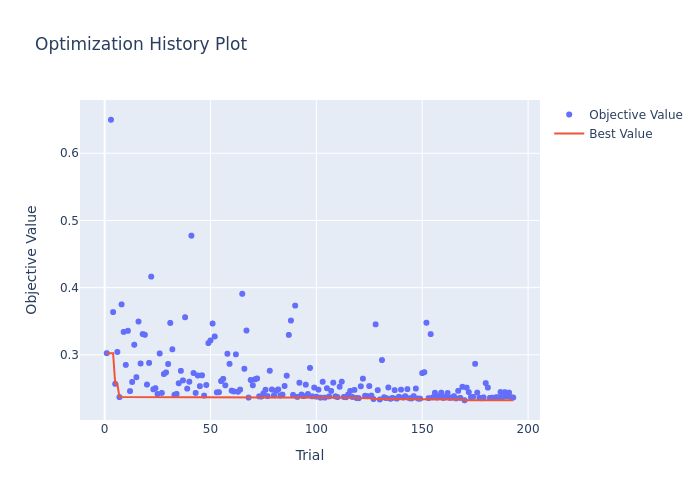

In [12]:
plot_optimization_history(study)

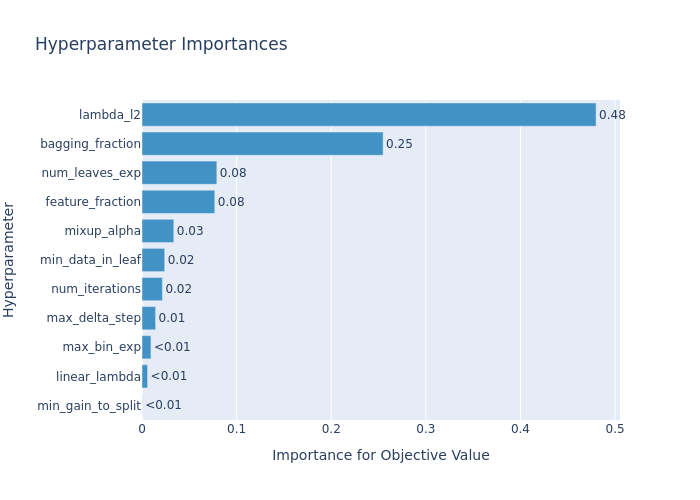

In [13]:
plot_param_importances(study)

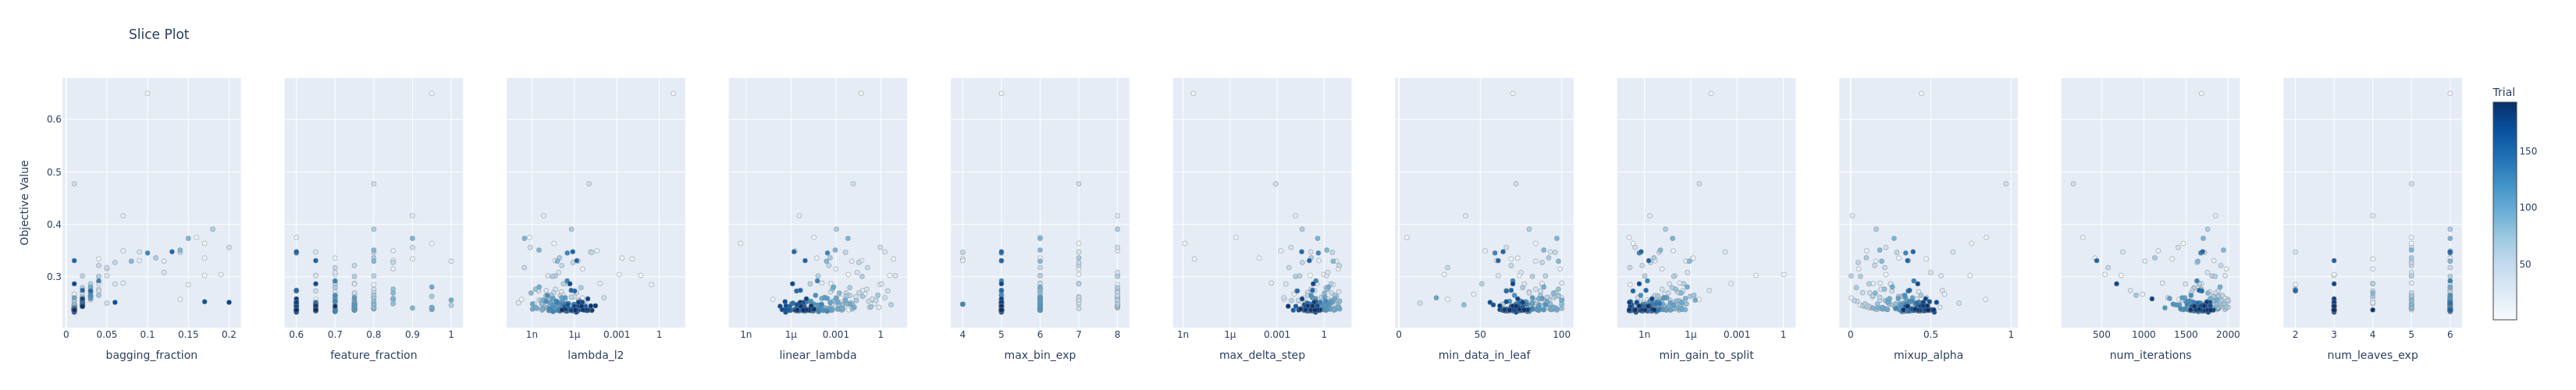

In [14]:
plot_slice(study)

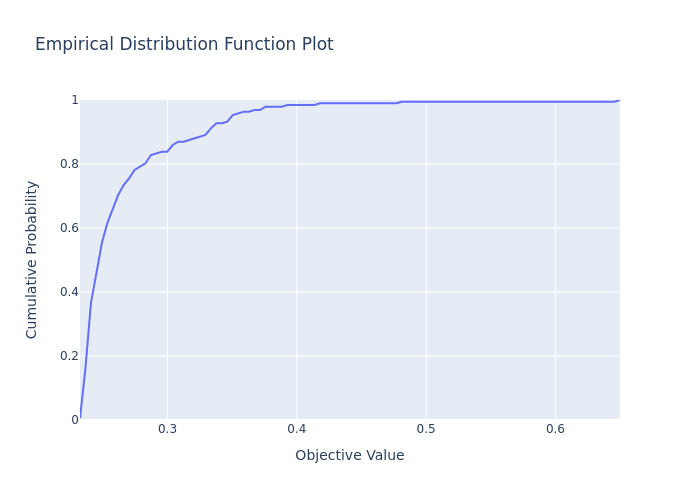

In [15]:
plot_edf(study)

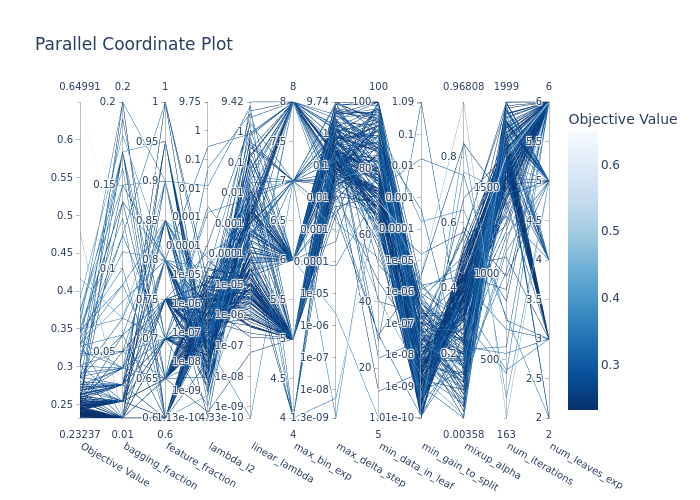

In [16]:
plot_parallel_coordinate(study)

In [17]:
best_params = dict(study.best_params)
best_params["max_bin"] = 2**best_params.pop("max_bin_exp")-1
best_params["num_leaves"] = 2**best_params.pop("num_leaves_exp")-1
best_params = {**DEFAULT_PARAMS, **best_params}
best_params

{'objective': 'binary',
 'metric': 'None',
 'learning_rate': 0.005,
 'seed': 2112,
 'deterministic': True,
 'first_metric_only': False,
 'feature_pre_filter': False,
 'verbosity': -1,
 'bin_construct_sample_cnt': 1000000,
 'linear_tree': True,
 'bagging_freq': 1,
 'bagging_fraction': 0.01,
 'feature_fraction': 0.6,
 'lambda_l2': 1.3796658469176682e-06,
 'linear_lambda': 4.3734070237266075e-07,
 'max_delta_step': 0.2821025082806922,
 'min_data_in_leaf': 72,
 'min_gain_to_split': 2.8056537456454624e-10,
 'mixup_alpha': 0.5216205235692403,
 'num_iterations': 1764,
 'max_bin': 31,
 'num_leaves': 7}

***